In [274]:
# 结构信息

In [275]:
import torch
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import time
from networkx.algorithms.bipartite.basic import color
from sympy.codegen.cnodes import struct

plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #显示负号
from   structure  import Structure

In [276]:
# 得到P
acc= pd.read_csv("../data/地震加速度.csv").iloc[251, 1:]
ag=np.array(acc)
n = ag.shape[0]
dt=0.02

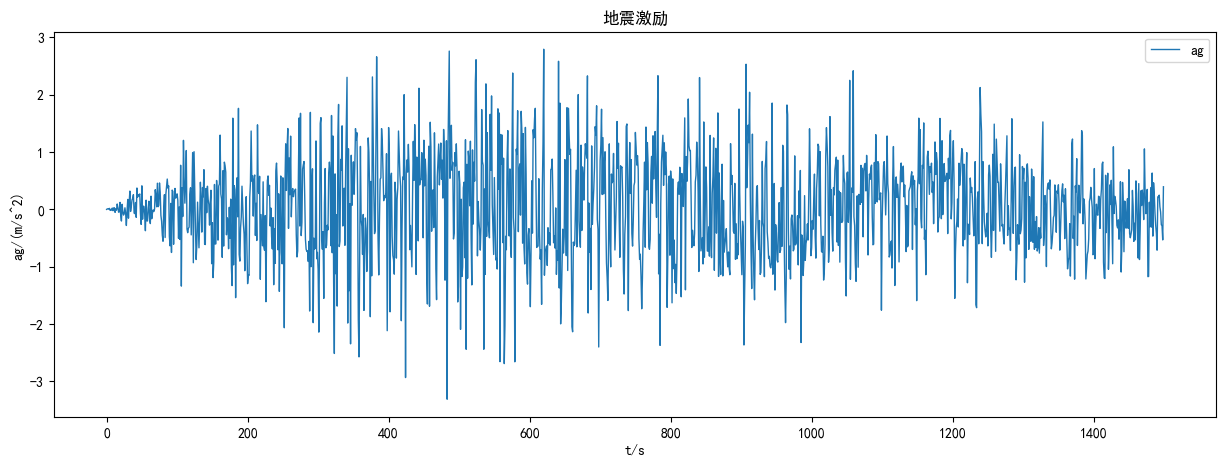

In [277]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(ag.shape[0]),ag, label='ag', linewidth=1)
plt.ylabel("ag/(m/s^2)")
plt.xlabel("t/s")
plt.legend(loc='best')
plt.title("地震激励")
plt.show()

In [278]:
m = torch.tensor([1000.0]*5)   ##单位：kg
k=[1e5]*5          ##单位 N*m/s

In [279]:
structure=Structure(dof=5,M=m,K=k,num_omega1=1,num_omega2=5,zeta=0.05)
K=torch.tensor(structure.K).float()
M=torch.tensor(structure.M).float()
C=torch.tensor(structure.C).float()

In [280]:
#定义、计算积分常数
beta = 0.25
gama = 0.5
a0 = (1 / beta / dt / dt)
a1 = (gama / beta / dt)
a2 = (1 / beta / dt)
a3 = (1 / 2 / beta - 1)
a4 = (gama / beta - 1)
a5 = (dt / 2 * (gama / beta - 2))
a6 = (dt * (1 - gama))
a7 = (dt * gama)

In [281]:
#形成等效刚度矩阵,建立结构运动状态0矩阵
dofs=5
u = torch.zeros((dofs, n))   
v = torch.zeros((dofs, n))
acc = torch.zeros((dofs, n))
du = torch.zeros((dofs, n))   #定义位移增量
u_re=torch.zeros((dofs, n))
Fre=torch.zeros((dofs, n))

In [282]:
KK = K
k_t=k[0]
yita=1000
min_iter=10

In [283]:
#增量方程形式逐步积分
timestamp1=time.time()
for i in range(1, n):
    
    KK[0,0]=k_t+k[1]
    
    dPP = -(ag[i] - ag[i - 1]) * m + M@(a2 * v[:, i - 1] + (a3 + 1) * acc[:, i - 1]) + C@((a4 + 1) * v[:, i - 1] + a5 * acc[:, i - 1])
    K_hat = KK + a0 * M + a1 * C          #形成相对刚度矩阵
    K_hat_inv = torch.linalg.inv(K_hat)
    du[:, i] = K_hat_inv@dPP     #相对刚度矩阵的逆与 外力变化值点乘  得到 位移变化值
    u[:, i] = u[:, i - 1] + du[:, i]      #得到本时间步结束时的总位移
    acc[:, i] = a0 * du[:, i] - a2 * v[:, i - 1] - a3 * acc[:, i - 1]       #计算加速度
    v[:, i] = a1 * du[:, i] - a4 * v[:, i - 1] - a5 * acc[:, i - 1]         #计算速度

    iter_count = 0
    while (du[0, i].abs()>1e-10 or iter_count<min_iter) and iter_count<1000:
        dPP = -(ag[i] - ag[i - 1]) * m + M@(a2 * v[:, i - 1] + (a3 + 1) * acc[:, i - 1]) + C@((a4 + 1) * v[:, i - 1] + a5 * acc[:, i - 1])
        K_hat = KK + a0 * M + a1 * C          
        K_hat_inv = torch.linalg.inv(K_hat)
        du[:, i] = K_hat_inv@dPP     
        u[:, i] = u[:, i - 1] + du[:, i]     
        acc[:, i] = a0 * du[:, i] - a2 * v[:, i - 1] - a3 * acc[:, i - 1]     
        v[:, i] = a1 * du[:, i] - a4 * v[:, i - 1] - a5 * acc[:, i - 1]
        iter_count +=1
    
    u_re[0,i]=u[0,i]
    u_re[1:,i]=u[1:,i]-u[0:4,i]
    k_t=k[0]+yita*k[0]*u_re[0,i]**2

timestamp2=time.time()
time_difference = timestamp2 - timestamp1
print("时间差（秒）：", time_difference)

时间差（秒）： 737.2965259552002


In [284]:
pd.DataFrame(u.numpy()).to_csv("result_data/Newmark_ns251_2.csv")

In [285]:
K_re=torch.tensor([
    [-k[0],k[1],0,0,0],
    [0,-k[1],k[2],0,0],
    [0,0,-k[2],k[3],0],
    [0,0,0,-k[3],k[4]],
    [0,0,0,0,-k[4]]])

In [286]:
F_re_nl=k[0]*(yita*u_re[0,:]**3)
F_re=torch.tensor(k).unsqueeze(1)*u_re
F_re[0,:]+=F_re_nl

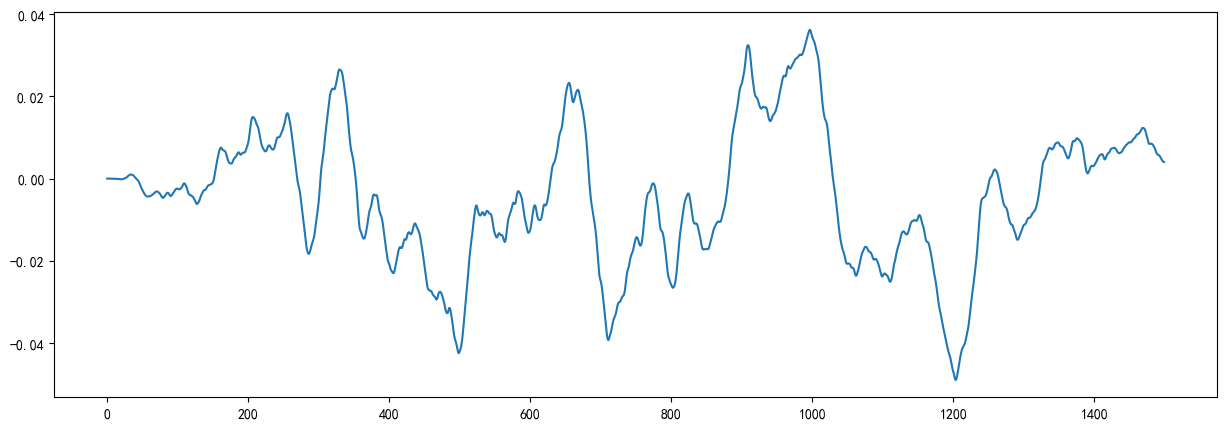

In [287]:
plt.figure(figsize=(15,5))
y=u[1,:]
plt.plot(range(len(y)),y)

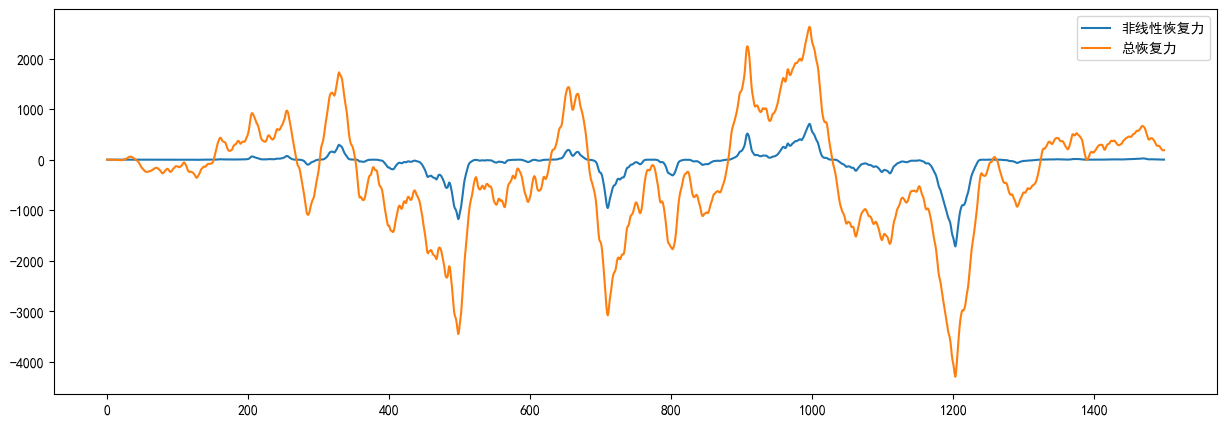

In [288]:
plt.figure(figsize=(15,5))
plt.plot(range(len(F_re_nl)),F_re_nl,label="非线性恢复力")
plt.plot(range(len(F_re[0,:])),F_re[0,:],label="总恢复力")
plt.legend(loc='best')
plt.show()